In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import re
import seaborn as sns
import sklearn
import warnings
import xgboost as xgb
%matplotlib inline
py.init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.model_selection import KFold
from sklearn.svm import SVC

In [3]:
# Load in the train and test datasets
train = pd.read_csv('./data/titanic/train.csv')
test = pd.read_csv('./data/titanic/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']                               = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']                                  = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age']                          = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [5]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [6]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


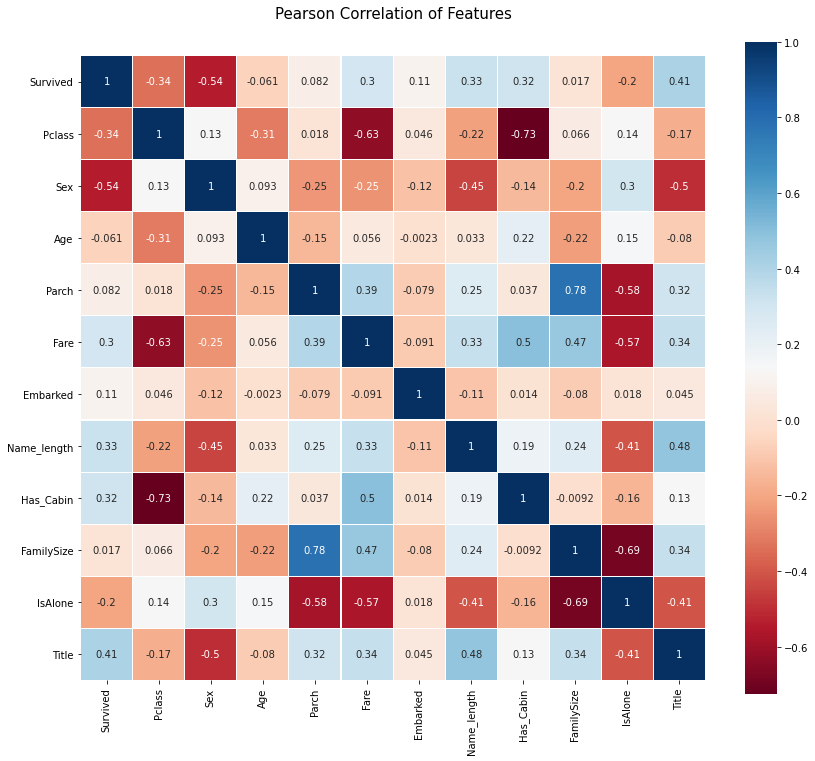

In [7]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

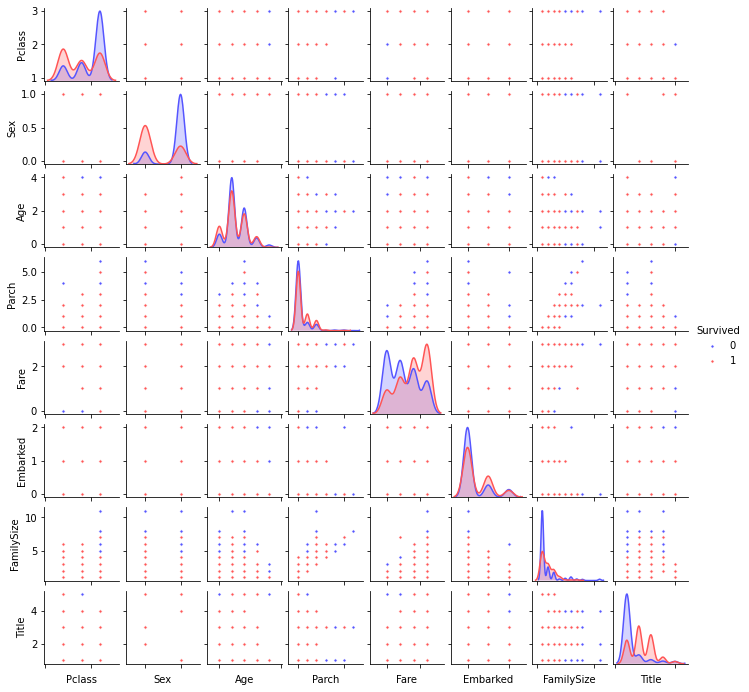

In [8]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

In [9]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

### Out-of-Fold Predictions

One cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training. This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

In [10]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

### Generating our Base First-Level Models

Five learning models as our first level classification:

1) Random Forest classifier

2) Extra Trees classifier

3) AdaBoost classifer

4) Gradient Boosting classifer

5) Support Vector Machine

In [11]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True, 
    #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

In [12]:
# Create 5 objects that represent our 5 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [13]:
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models

y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [14]:
# Create our OOF train and test predictions. These base results will be used as new features

et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
print("Extra Trees is complete")

rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test) # Random Forest
print("Random Forest is complete")

ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
print("AdaBoost is complete")

gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test) # Gradient Boost
print("Gradient Boost is complete")

svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test) # Support Vector Classifier
print("Support Vector Classifier is complete")

Extra Trees is complete
Random Forest is complete
AdaBoost is complete
Gradient Boost is complete
Support Vector Classifier is complete


### Feature importances generated from the different classifiers

Now having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models and that is to output the importances of the various features in the training and test sets with one very simple line of code.

In [15]:
et_feature = et.feature_importances(x_train, y_train)
rf_feature = rf.feature_importances(x_train,y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.11959127 0.3793616  0.02581523 0.01696351 0.05502765 0.02881573
 0.04708333 0.0835736  0.04471594 0.02242897 0.17662318]
[0.10341695 0.21229052 0.03117032 0.01998668 0.04825164 0.02969041
 0.13068884 0.04914661 0.0728307  0.01180098 0.29072635]
[0.028 0.01  0.018 0.066 0.04  0.01  0.686 0.012 0.052 0.006 0.072]
[0.08930967 0.0133486  0.04916407 0.01468361 0.04908923 0.02452318
 0.1745042  0.03604138 0.11153629 0.00578672 0.43201305]


In [16]:
et_features = [0.11971984, 0.3785038,  0.02944455, 0.01655806, 0.05576063, 0.02919331, 
               0.04753264, 0.08456041, 0.04511643, 0.02107407, 0.17253626]

rf_features = [0.1048154,  0.20922709, 0.03527825, 0.01968099, 0.04862607, 0.02796291, 
               0.1291824,  0.04931971, 0.07203406, 0.0121091,  0.29176402]

ada_features = [0.028, 0.008, 0.016, 0.072, 0.04,  0.01,  0.69,  0.012, 0.054, 0.004, 0.066]

gb_features = [0.08555864, 0.01263711, 0.04929375, 0.01404269, 0.0495662,  0.02398692, 
               0.17536449, 0.03932509, 0.11601879, 0.00462655, 0.42957978]

In [17]:
cols = train.columns.values

# Create a dataframe with features
feature_dataframe = pd.DataFrame({'features': cols,
                                  'Random_Forest_Feature_Importances': rf_features,
                                  'Extra_Trees_Feature_Importances': et_features,
                                  'AdaBoost_Feature_Importances': ada_features,
                                  'Gradient_Boost_Feature_Importances': gb_features
                                 })

### Interactive feature importances via Plotly scatterplots

In [18]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random_Forest_Feature_Importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random_Forest_Feature_Importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random_Forest_Feature_Importances',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra_Trees_Feature_Importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra_Trees_Feature_Importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra_Trees_Feature_Importances',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost_Feature_Importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost_Feature_Importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost_Feature_Importances',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient_Boost_Feature_Importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient_Boost_Feature_Importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient_Boost_Feature_Importances',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [19]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random_Forest_Feature_Importances,Extra_Trees_Feature_Importances,AdaBoost_Feature_Importances,Gradient_Boost_Feature_Importances,mean
0,Pclass,0.104815,0.119720,0.028,0.085559,0.084523
1,Sex,0.209227,0.378504,0.008,0.012637,0.152092
2,Age,0.035278,0.029445,0.016,0.049294,0.032504


### Plotly Barplot of Average Feature Importances

In [20]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values

data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

## Second-Level Predictions from the First-level Output

### First-level output as new features

Having now obtained our first-level predictions, one can think of it as essentially building a new set of features to be used as training data for the next classifier. As per the code below, we are therefore having as our new columns the first-level predictions from our earlier classifiers and we train the next classifier on this.

In [21]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })

base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [22]:
# Correlation Heatmap of the Second Level Training set

data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]

py.iplot(data, filename='labelled-heatmap')

In [23]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)

x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

Having now concatenated and joined both the first-level train and test predictions as x_train and x_test, we can now fit a second-level learning model.

### Second level learning model via XGBoost

We call an XGBClassifier and fit it to the first-level train and target data and use the learned model to predict the test data as follows:

In [24]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
    n_estimators= 2000,
    max_depth= 4,
    min_child_weight= 2,
    gamma=0.9,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread= -1,
    scale_pos_weight=1).fit(x_train, y_train)

predictions = gbm.predict(x_test)

[13:25:47] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [25]:
predictions

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,